# Prediction of Health Measures Based on Location

**Data Scientist:** Elina Rankova

[IMAGE PLACEHOLDER]



## 1. Business Problem and Understanding

In [88]:
# Import libraries

import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
GradientBoostingRegressor, VotingRegressor, StackingRegressor
from metrics_cv import MetricsCV
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
%load_ext autoreload
%autoreload 2
# import warnings
# warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
MetricsCV??

Init signature: MetricsCV(pipe, pipe_name, X_train, y_train, random_state=None)
Source:        
class MetricsCV():
    ''' Create CV metrics with hyperparameter tuning'''

    def __init__(self,pipe,pipe_name,X_train,y_train,random_state=None):

        self.model = pipe
        self.name = pipe_name
        self.X_train = X_train
        self.y_train = y_train
        self.random_state = random_state

    
    def objective(self,space,scoring, n_calls=50, n_initial_points=10, verbose=None, pipe=None,
                  X_train=None,y_train=None,kfolds=5,return_train_score=True, val_df=None):

        # Ensuring that the pipe and data used are either passed to the method or the instance defaults
        obj_pipe = pipe if pipe else self.model
        obj_X = X_train if X_train else self.X_train
        obj_y = y_train if y_train else self.y_train

        @use_named_args(space)
        def objective_function(**params):
            # Set the hyperparameters on the model
            self.

## 2. Data Understanding

In [3]:
# Load datasets

pl1 = pd.read_csv('Data/PLACES_2017-2018.csv')
pl2 = pd.read_csv('Data/PLACES_2018-2019.csv')
pl3 = pd.read_csv('Data/PLACES_2019-2020.csv')
pl4 = pd.read_csv('Data/PLACES_2020-2021.csv')
sdoh = pd.read_csv('Data/SDOH_2017-2021.csv')

We may want to check on the `StateAbbr` and `StateDesc` since it's showing the country in the preview. We also want to adjust the LocationName to either exclude 'county' or include 'county' to make sure both of the datasets are aligned in nomenclature.

Since the data we are working with is by county, we can eliminate the added specification with the `LocationName` in the SDOH dataset.

We will also have to deal with the differences in the `Year` column since it is an object in the SDOH data and an integer in the PLACES data.

In [4]:
# Concat all PLACES datasets
pl_all = pd.concat([pl1, pl2, pl3, pl4])
display(pl_all.tail())

sdoh.head()

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,High_Confidence_Limit,TotalPopulation,Latitude,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocatioin,LocationID,Geolocation
228765,2021,TX,Texas,Brown,BRFSS,Health Outcomes,High cholesterol among adults aged >=18 years ...,%,Crude prevalence,40.4,...,45.5,38192,NaN,HLTHOUT,HIGHCHOL,CrdPrv,High Cholesterol,NaN,48049.0,POINT (-98.998456 31.7641372)
228766,2021,TX,Texas,Grayson,BRFSS,Health Outcomes,Chronic kidney disease among adults aged >=18 ...,%,Age-adjusted prevalence,2.8,...,3.2,139336,NaN,HLTHOUT,KIDNEY,AgeAdjPrv,Chronic Kidney Disease,NaN,48181.0,POINT (-96.675693 33.624524)
228767,2021,SC,South Carolina,Richland,BRFSS,Health Risk Behaviors,No leisure-time physical activity among adults...,%,Crude prevalence,23.9,...,27.5,418307,NaN,RISKBEH,LPA,CrdPrv,Physical Inactivity,NaN,45079.0,POINT (-80.8980371 34.0290952)
228768,2021,WA,Washington,Franklin,BRFSS,Disability,Independent living disability among adults age...,%,Crude prevalence,8.4,...,9.8,98268,NaN,DISABLT,INDEPLIVE,CrdPrv,Independent Living Disability,NaN,53021.0,POINT (-118.9038912 46.5375019)
228769,2020,WI,Wisconsin,La Crosse,BRFSS,Health Outcomes,All teeth lost among adults aged >=65 years,%,Crude prevalence,8.1,...,11.8,120433,NaN,HLTHOUT,TEETHLOST,CrdPrv,All Teeth Lost,NaN,55063.0,POINT (-91.1117584 43.9082222)


,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,MOE,TotalPopulation,LocationID,CategoryID,MeasureID,DataValueTypeID,Short_Question_Text,Geolocation
0,2017-2021,AL,Alabama,Coosa County,5-year ACS,SDOH,Housing cost burden among households,%,Percentage,12.8,4.0,10442,1037,SDOH,HCOST,Percent,Housing cost burden,POINT (-86.2434818 32.9314453)
1,2017-2021,AL,Alabama,Lamar County,5-year ACS,SDOH,Persons living below 150% of the poverty level,%,Percentage,27.4,4.0,13929,1075,SDOH,POV150,Percent,Poverty,POINT (-88.0874309 33.7870852)
2,2017-2021,AK,Alaska,Aleutians East Borough,5-year ACS,SDOH,Crowding among housing units,%,Percentage,4.6,2.3,3409,2013,SDOH,CROWD,Percent,Crowding,POINT (-161.9974772 55.2450437)
3,2017-2021,AR,Arkansas,Dallas County,5-year ACS,SDOH,Crowding among housing units,%,Percentage,2.3,2.2,6645,5039,SDOH,CROWD,Percent,Crowding,POINT (-92.6539989 33.9678233)
4,2017-2021,AR,Arkansas,Franklin County,5-year ACS,SDOH,Crowding among housing units,%,Percentage,2.6,1.8,17159,5047,SDOH,CROWD,Percent,Crowding,POINT (-93.8876647 35.5085579)


In [5]:
# Lowercase all data to ensure consistancy
sdoh = sdoh.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
pl_all = pl_all.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Delete the 'county' specification
sdoh['LocationName'] = sdoh['LocationName'].str.replace('county',"")

In [6]:
print(sdoh.info())
print(pl_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28287 entries, 0 to 28286
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 28287 non-null  object 
 1   StateAbbr            28287 non-null  object 
 2   StateDesc            28287 non-null  object 
 3   LocationName         28278 non-null  object 
 4   DataSource           28287 non-null  object 
 5   Category             28287 non-null  object 
 6   Measure              28287 non-null  object 
 7   Data_Value_Unit      28287 non-null  object 
 8   Data_Value_Type      28287 non-null  object 
 9   Data_Value           28287 non-null  float64
 10  MOE                  28285 non-null  float64
 11  TotalPopulation      28287 non-null  int64  
 12  LocationID           28287 non-null  int64  
 13  CategoryID           28287 non-null  object 
 14  MeasureID            28287 non-null  object 
 15  DataValueTypeID      28287 non-null 

We will have to drop `Low_Confidence_Limit` and `High_Confidence_Limit` since the SDOH dataset does not have these columns.

In [7]:
print(sdoh.isna().sum()/sdoh.shape[0],'\n')
print(pl_all.isna().sum()/pl_all.shape[0])

Year                   0.000000
StateAbbr              0.000000
StateDesc              0.000000
LocationName           0.000318
DataSource             0.000000
Category               0.000000
Measure                0.000000
Data_Value_Unit        0.000000
Data_Value_Type        0.000000
Data_Value             0.000000
MOE                    0.000071
TotalPopulation        0.000000
LocationID             0.000000
CategoryID             0.000000
MeasureID              0.000000
DataValueTypeID        0.000000
Short_Question_Text    0.000000
Geolocation            0.000318
dtype: float64 

Year                          0.000000
StateAbbr                     0.000000
StateDesc                     0.000000
LocationName                  0.000320
DataSource                    0.000000
Category                      0.000000
Measure                       0.000000
Data_Value_Unit               0.000000
Data_Value_Type               0.000000
Data_Value                    0.000000
Data_Value_Footno

In [8]:
# Merge all datasets together
df_all = pd.concat([pl_all, sdoh])

Right away we can tell that there are a few columns that are missing too many values and will need to be dropped.
- `Data_Value_Footnote_Symbol`
- `Data_Value_Footnote`
- `Latitude`
- `MOE`

`Geolocatioin` and `Geolocation` are the same feature when checking the source data websites only the 2020 release has a `Geolocatioin` column while the rest have `Geolocation`. `MeasureID` and `MeasureId` have the same issue it seems.

There are object type columns that will need to be transformed. Since state should be treated as a categorical variable we should adjust this in our dataset.

In addition, we would also want to make `LocationID` an object since this is not an actual continuous variable.

In [9]:
print(df_all.info(),'\n')

# Drop unneeded columns
df_all.drop(columns=['Data_Value_Footnote_Symbol','Data_Value_Footnote','Latitude',
                     'MOE','Low_Confidence_Limit','High_Confidence_Limit'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 809177 entries, 0 to 28286
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Year                        809177 non-null  object 
 1   StateAbbr                   809177 non-null  object 
 2   StateDesc                   809177 non-null  object 
 3   LocationName                808918 non-null  object 
 4   DataSource                  809177 non-null  object 
 5   Category                    809177 non-null  object 
 6   Measure                     809177 non-null  object 
 7   Data_Value_Unit             809177 non-null  object 
 8   Data_Value_Type             809177 non-null  object 
 9   Data_Value                  809177 non-null  float64
 10  Data_Value_Footnote_Symbol  0 non-null       float64
 11  Data_Value_Footnote         0 non-null       float64
 12  Low_Confidence_Limit        780890 non-null  float64
 13  High_Confidence_Limi

We can drop the misspelled `Geolocatioin` after filling in the nas in `Geolocation`. This concept applies to `MeasureID` and `MeasureId` as well.

In [10]:
# Fill NaNs in Geolocation and with Geolocatioin
df_all.loc[df_all['Geolocation'].isna(), 'Geolocation'] = df_all.loc[df_all['Geolocation'].isna(), 'Geolocatioin']

# Apply the same method to `MeasureID
df_all.loc[df_all['MeasureID'].isna(), 'MeasureID'] = df_all.loc[df_all['MeasureID'].isna(), 'MeasureId']

# Drop unneeded columns
df_all.drop(columns=['MeasureId','Geolocatioin'],axis=1,inplace=True)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 809177 entries, 0 to 28286
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 809177 non-null  object 
 1   StateAbbr            809177 non-null  object 
 2   StateDesc            809177 non-null  object 
 3   LocationName         808918 non-null  object 
 4   DataSource           809177 non-null  object 
 5   Category             809177 non-null  object 
 6   Measure              809177 non-null  object 
 7   Data_Value_Unit      809177 non-null  object 
 8   Data_Value_Type      809177 non-null  object 
 9   Data_Value           809177 non-null  float64
 10  TotalPopulation      809177 non-null  int64  
 11  CategoryID           809177 non-null  object 
 12  DataValueTypeID      809177 non-null  object 
 13  Short_Question_Text  809177 non-null  object 
 14  LocationID           633169 non-null  float64
 15  Geolocation          80

We can drop nas in any columns we are not already dropping such as `LocationName` and the updated `Geolocation`. `LocationID` refers to the zipcode so we should first see if we can impute with the proper zipcode before droping nas.

In [11]:
print(df_all.isna().sum()/df_all.shape[0])

df_all.dropna(subset=['LocationName','Geolocation'],inplace=True)

Year                   0.000000
StateAbbr              0.000000
StateDesc              0.000000
LocationName           0.000320
DataSource             0.000000
Category               0.000000
Measure                0.000000
Data_Value_Unit        0.000000
Data_Value_Type        0.000000
Data_Value             0.000000
TotalPopulation        0.000000
CategoryID             0.000000
DataValueTypeID        0.000000
Short_Question_Text    0.000000
LocationID             0.217515
Geolocation            0.000320
MeasureID              0.000000
dtype: float64


Looks like we were able to fill the nas using the associated `LocationID` with existing `Geolocation` as a unique identifier for the zipcode. 

In [12]:
# Filter rows with non-null LocationID
loc_df = df_all.loc[df_all['LocationID'].notna(), ['Geolocation', 'LocationID']]

# Create LocationName <> LocationID dictionary
loc_dict = dict(zip(loc_df['Geolocation'], loc_df['LocationID']))

# Fill missing LocationID values based on LocationName from the dictionary
df_all['LocationID'] = df_all['LocationID'].fillna(df_all['Geolocation'].map(loc_dict))

# Drop the rest of the nas in LocationID
df_all.dropna(inplace=True)

# Check the percentage of missing values in df_all after filling missing values
print(df_all.isna().sum() / df_all.shape[0])

Year                   0.0
StateAbbr              0.0
StateDesc              0.0
LocationName           0.0
DataSource             0.0
Category               0.0
Measure                0.0
Data_Value_Unit        0.0
Data_Value_Type        0.0
Data_Value             0.0
TotalPopulation        0.0
CategoryID             0.0
DataValueTypeID        0.0
Short_Question_Text    0.0
LocationID             0.0
Geolocation            0.0
MeasureID              0.0
dtype: float64


In [13]:
# Convert 'StateAbbr' and 'LocationID' columns to appropriate type
df_all['StateAbbr'] = df_all['StateAbbr'].astype('category')
df_all['LocationID'] = df_all['LocationID'].astype('object')

### Column Exploration

<ins>**Observations**</ins>

- We will likely drop `Year` as it can only provide relevant information for the data we retrieved from the PLACES datasets. Otherwise, we have the same date range as seen in the added SDOH data (2017-2021).
- Looks like we may want to drop the rows with US as the state as it is an error. We can also drop `StateDesc` since it's the same info as `StateAbbr`.
- `DataSource` can be dropped since all of the information is coming from the Behavioral Risk Factor Surveillance System or the 5-year American Community Survey which only contains SDOH data.
- `Data_Value_Unit` can be dropped since all of our data values are in percentages.
- `Data_Value_Type` will be helpful for interpretation of our predictions since it denotes what percentage the `Data_Value` represents. `DataValueTypeID` corresponds to this feature and can be dropped since `Data_Value_Type` is more informative. 
- `CategoryID` corresponds to `Category` so we can drop it since `Category is easier to interpret.
- `MeasureId` corresponds the same way to `Measure`. However `Measure` values can be quite lengthy depending on the measure. We also have `Short_Question_Text` corresponding to these features and is more informative than `MeausureId` but shorter than `Measure` so we will keep `Short_Question_Text` and create a reference dictionary before dropping the other columns.

In [14]:
print(df_all['Year'].value_counts(),'\n')
print(df_all['StateAbbr'].value_counts(),'\n')
print(df_all['DataSource'].value_counts(),'\n')
print(df_all['Data_Value_Unit'].value_counts(),'\n')
print(df_all['Data_Value_Type'].value_counts(),'\n')
print(df_all['CategoryID'].value_counts(),'\n')
print(df_all['MeasureID'].value_counts(),'\n')
print(df_all['DataValueTypeID'].value_counts(),'\n')
print(df_all['Short_Question_Text'].value_counts(),'\n')

Year
2020         213724
2018         201040
2021         178408
2019         162284
2017-2021     28278
2017          25128
Name: count, dtype: int64 

StateAbbr
tx    65786
ga    41181
va    34391
ky    31080
mo    29785
ks    27195
il    26418
nc    25900
ia    25641
tn    24605
ne    24087
in    23828
oh    22792
mn    22533
mi    21497
ms    21238
ok    19943
ar    19425
wi    18648
al    17353
pa    17353
sd    17094
la    16576
co    16576
ny    16058
ca    15022
mt    14504
wv    14245
nd    13727
fl    13467
sc    11914
id    11396
wa    10101
or     9324
nm     8547
ak     7638
ut     7511
md     6216
wy     5957
nv     4403
nj     4347
me     4144
az     3885
ma     3626
vt     3626
nh     2590
ct     2072
ri     1295
hi     1286
de      777
dc      259
Name: count, dtype: int64 

DataSource
brfss         780584
5-year acs     28278
Name: count, dtype: int64 

Data_Value_Unit
%    808862
Name: count, dtype: int64 

Data_Value_Type
crude prevalence           390292
age-adjust

In [15]:
# Create reference dictionary for category and measure
measure_df = df_all[['Measure','Short_Question_Text','MeasureID']]
measure_dict = dict(zip(measure_df['MeasureID'], zip(measure_df['Short_Question_Text'], measure_df['Measure'])))
category_df = df_all[['Category','CategoryID']]
category_dict = dict(zip(category_df['Category'],category_df['CategoryID']))

In [16]:
# Drop rows with US as state
df_all = df_all.loc[df_all['StateAbbr'] != 'US']

# Drop other relevant columns
df_all.drop(columns=['DataSource','Data_Value_Unit','CategoryID','DataValueTypeID',
                     'StateDesc', 'MeasureID','Year','Measure'],inplace=True)
df_all.columns

Index(['StateAbbr', 'LocationName', 'Category', 'Data_Value_Type',
       'Data_Value', 'TotalPopulation', 'Short_Question_Text', 'LocationID',
       'Geolocation'],
      dtype='object')

Let's quickly check for duplicates since we had to download all of the PLACES datasets separately to accomodate the year range in the SDOH dataset.

In [17]:
dups = df_all.duplicated()
dups.value_counts()

False    808694
True        168
Name: count, dtype: int64

In [18]:
# Drop identified duplicates
df_all.drop_duplicates(ignore_index=True, inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808694 entries, 0 to 808693
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            808694 non-null  category
 1   LocationName         808694 non-null  object  
 2   Category             808694 non-null  object  
 3   Data_Value_Type      808694 non-null  object  
 4   Data_Value           808694 non-null  float64 
 5   TotalPopulation      808694 non-null  int64   
 6   Short_Question_Text  808694 non-null  object  
 7   LocationID           808694 non-null  object  
 8   Geolocation          808694 non-null  object  
dtypes: category(1), float64(1), int64(1), object(6)
memory usage: 50.1+ MB


### Statistical Analysis

Before we move onto defining the target, we should look at the numerical distribution of the `Data_Value` and `TotalPopulation` columns. 

We can see there are some outliers in both columns we should consider visualizing and potentially dropping to get a more accurate representation of our distributions.

We will want to consider normalizing the `Data_Value` column since the values are represented differently based on type. We can also consider weighing it if we consider one type more important than another.

In [19]:
df_all[['Data_Value','TotalPopulation']].describe()

,Data_Value,TotalPopulation
count,808694.000000,8.086940e+05
mean,30.404016,1.033569e+05
std,24.766709,3.318928e+05
min,0.000000,5.700000e+01
25%,10.700000,1.080600e+04
50%,22.100000,2.562900e+04
75%,40.200000,6.749000e+04
max,99.400000,1.010552e+07


When visualizing these features, we can estimate that any `Data_Value` above ~85 is an outlier. It is harder to determine for `TotalPopulation`. We should look at the values of these more closely.

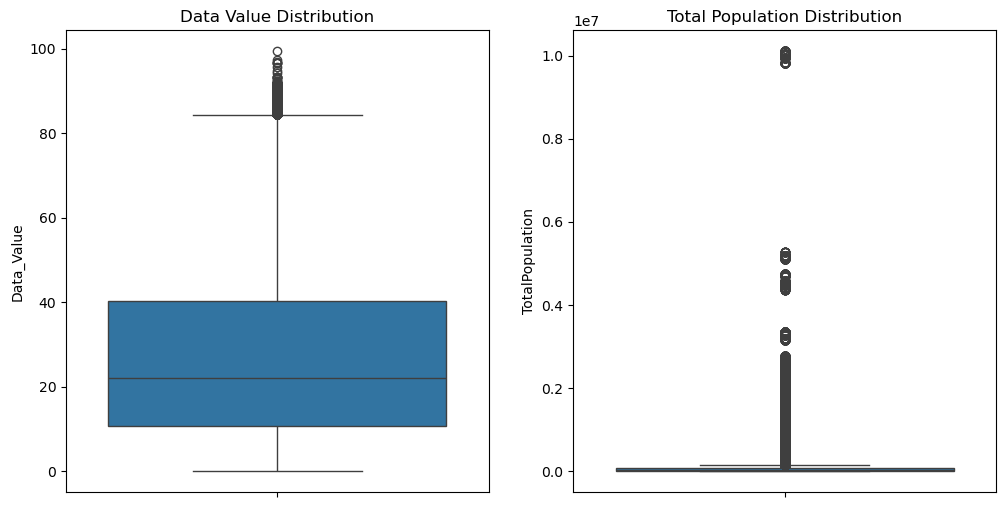

In [20]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
sns.boxplot(df_all['Data_Value'],ax=ax[0])
ax[0].set_title('Data Value Distribution')

sns.boxplot(df_all['TotalPopulation'],ax=ax[1])
ax[1].set_title('Total Population Distribution');

Looking at our z-score distribution there are around 10000 rows with a `TotalPopulation` greater than 3 standard deviations ouside the mean. All of the `Data_Value` is within 3 standard deviations within the mean so we won't drop those values quite yet. 

In [21]:
# Create subset df and get zscores
df_sub = df_all[['TotalPopulation','Data_Value']]
zscores = zscore(df_sub)

# Identify how many rows we would be dropping
print('Total Population > 3a std outside the mean:',zscores.loc[(zscores['TotalPopulation']<-3)|
      (zscores['TotalPopulation']>3)].shape[0])
print('Data Value > 3 std outside the mean:',zscores.loc[(zscores['Data_Value']<-3)|
      (zscores['Data_Value']>3)].shape[0])

Total Population > 3a std outside the mean: 10291
Data Value > 3 std outside the mean: 0


In [22]:
# Identify rows in df
outlier_rows = ((zscore(df_all['TotalPopulation'])>3)|(zscore(df_all['TotalPopulation'])<-3))

df_norm = df_all.loc[~outlier_rows].copy()

print(df_all.shape)
print(df_norm.shape)

(808694, 9)
(798403, 9)


It looks like our Data Value distribution for each Data Value Type isn't completely normal. So before we move on using it to create the HDI we want to normalize it using the `MinMaxScaler`.

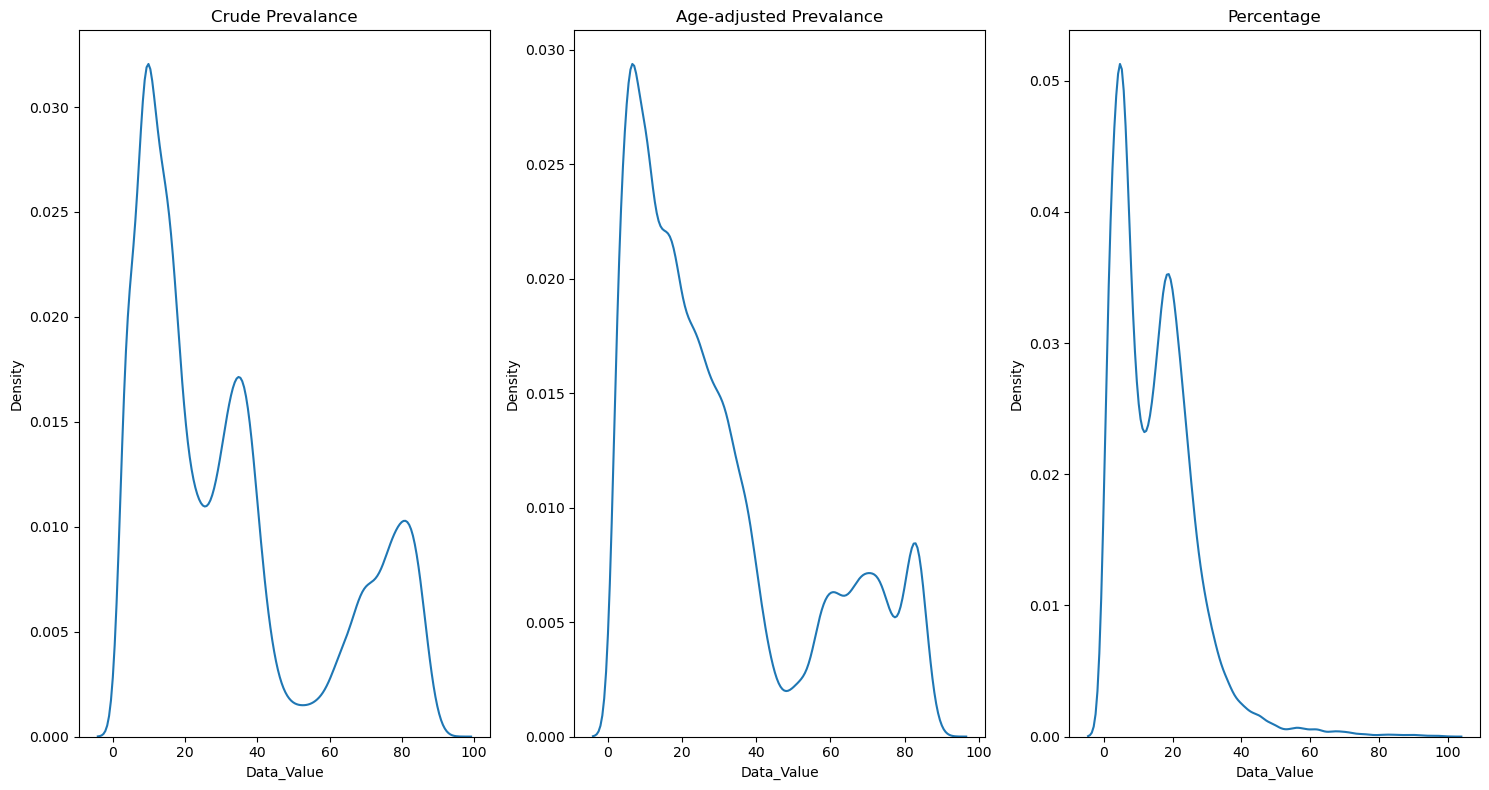

In [24]:
fig, ax = plt.subplots(ncols=3,figsize=(15,8))

sns.kdeplot(df_norm['Data_Value'].loc[df_norm['Data_Value_Type']=='crude prevalence'],ax=ax[0])
ax[0].set_title('Crude Prevalance')
sns.kdeplot(df_norm['Data_Value'].loc[df_norm['Data_Value_Type']=='age-adjusted prevalence'],ax=ax[1])
ax[1].set_title('Age-adjusted Prevalance')
sns.kdeplot(df_norm['Data_Value'].loc[df_norm['Data_Value_Type']=='percentage'],ax=ax[2])
ax[2].set_title('Percentage')
plt.tight_layout();

In [53]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Create an empty column for scaled values in the original DataFrame
df_norm.loc[:, 'Scaled_Value'] = pd.NA

# Process each data type separately
for data_type in df_norm['Data_Value_Type'].unique():
    # Filter the df to only include rows of the current data type
    subset = df_norm[df_norm['Data_Value_Type'] == data_type]
    
    # Note: .values.reshape(-1, 1) is used because scaler expects a 2D array
    scaled_values = scaler.fit_transform(subset['Data_Value'].values.reshape(-1, 1))

    # Assign the scaled values back to the appropriate rows in the main DataFrame
    df_norm.loc[subset.index, 'Scaled_Value'] = scaled_values.flatten()

# Ensure the scaled value is a float
df_norm['Scaled_Value'] = df_norm['Scaled_Value'].astype('float')


df_norm.info()

/var/folders/54/6dlx39k12qb_f13kgx_rz95m0000gn/T/ipykernel_73706/1083094882.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_norm.loc[:, 'Scaled_Value'] = pd.NA


<class 'pandas.core.frame.DataFrame'>
Index: 798403 entries, 0 to 808693
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            798403 non-null  category
 1   LocationName         798403 non-null  object  
 2   Category             798403 non-null  object  
 3   Data_Value_Type      798403 non-null  object  
 4   Data_Value           798403 non-null  float64 
 5   TotalPopulation      798403 non-null  int64   
 6   Short_Question_Text  798403 non-null  object  
 7   LocationID           798403 non-null  object  
 8   Geolocation          798403 non-null  object  
 9   Scaled_Value         798403 non-null  float64 
dtypes: category(1), float64(2), int64(1), object(6)
memory usage: 77.8+ MB


Before moving onto defining our target, lets check for outliers in our new `Scaled_Value` column.

In [27]:
# Create subset df and get zscores
scaled_zscores = zscore(df_norm['Scaled_Value'])

# Identify how many records are outside of 3 std outside the mean
outliers = np.abs(scaled_zscores) > 3
outlier_count = np.sum(outliers)

print('Total Scaled Values > 3 std outside the mean:', outlier_count)

Total Scaled Values > 3 std outside the mean: 0


### Defining the Target

Now that our dataframe is aligned with our project goals, we can define our target variable `Health_Disparity_Index`. 

To start, we will create a general index taking the sum of all scaled values for each location and create a feature in the full dataset to represent this disparity index. 

In [55]:
# Aggregate Scaled_Value per Geoplocation
sum_idx = df_norm.groupby('Geolocation')['Scaled_Value'].sum().reset_index()
sum_idx.rename({'Scaled_Value': 'Sum_Idx'},axis=1,inplace=True)

# Copy dataframe
df_sum_idx = df_norm.copy()

# Create new column
df_sum_idx = df_sum_idx.merge(sum_idx,on='Geolocation')
df_sum_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798403 entries, 0 to 798402
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            798403 non-null  category
 1   LocationName         798403 non-null  object  
 2   Category             798403 non-null  object  
 3   Data_Value_Type      798403 non-null  object  
 4   Data_Value           798403 non-null  float64 
 5   TotalPopulation      798403 non-null  int64   
 6   Short_Question_Text  798403 non-null  object  
 7   LocationID           798403 non-null  object  
 8   Geolocation          798403 non-null  object  
 9   Scaled_Value         798403 non-null  float64 
 10  Sum_Idx              798403 non-null  float64 
dtypes: category(1), float64(3), int64(1), object(6)
memory usage: 61.7+ MB


Comparing random samples of `Sum_Idx` vs `Data_Value` shows us that there is a lot more variablity in the `Scaked_Value` before aggregation of all of the data value types. This makes sense since our aggregated `Sum_Idx` is combining all values per geolocation, creating and therefore creates less variability when visualizing by location.

> It looks like we are also seeing geographical distinction when it comes to overall health disparity. This would make sense if for example, this segregation is representing rural vs urban areas.

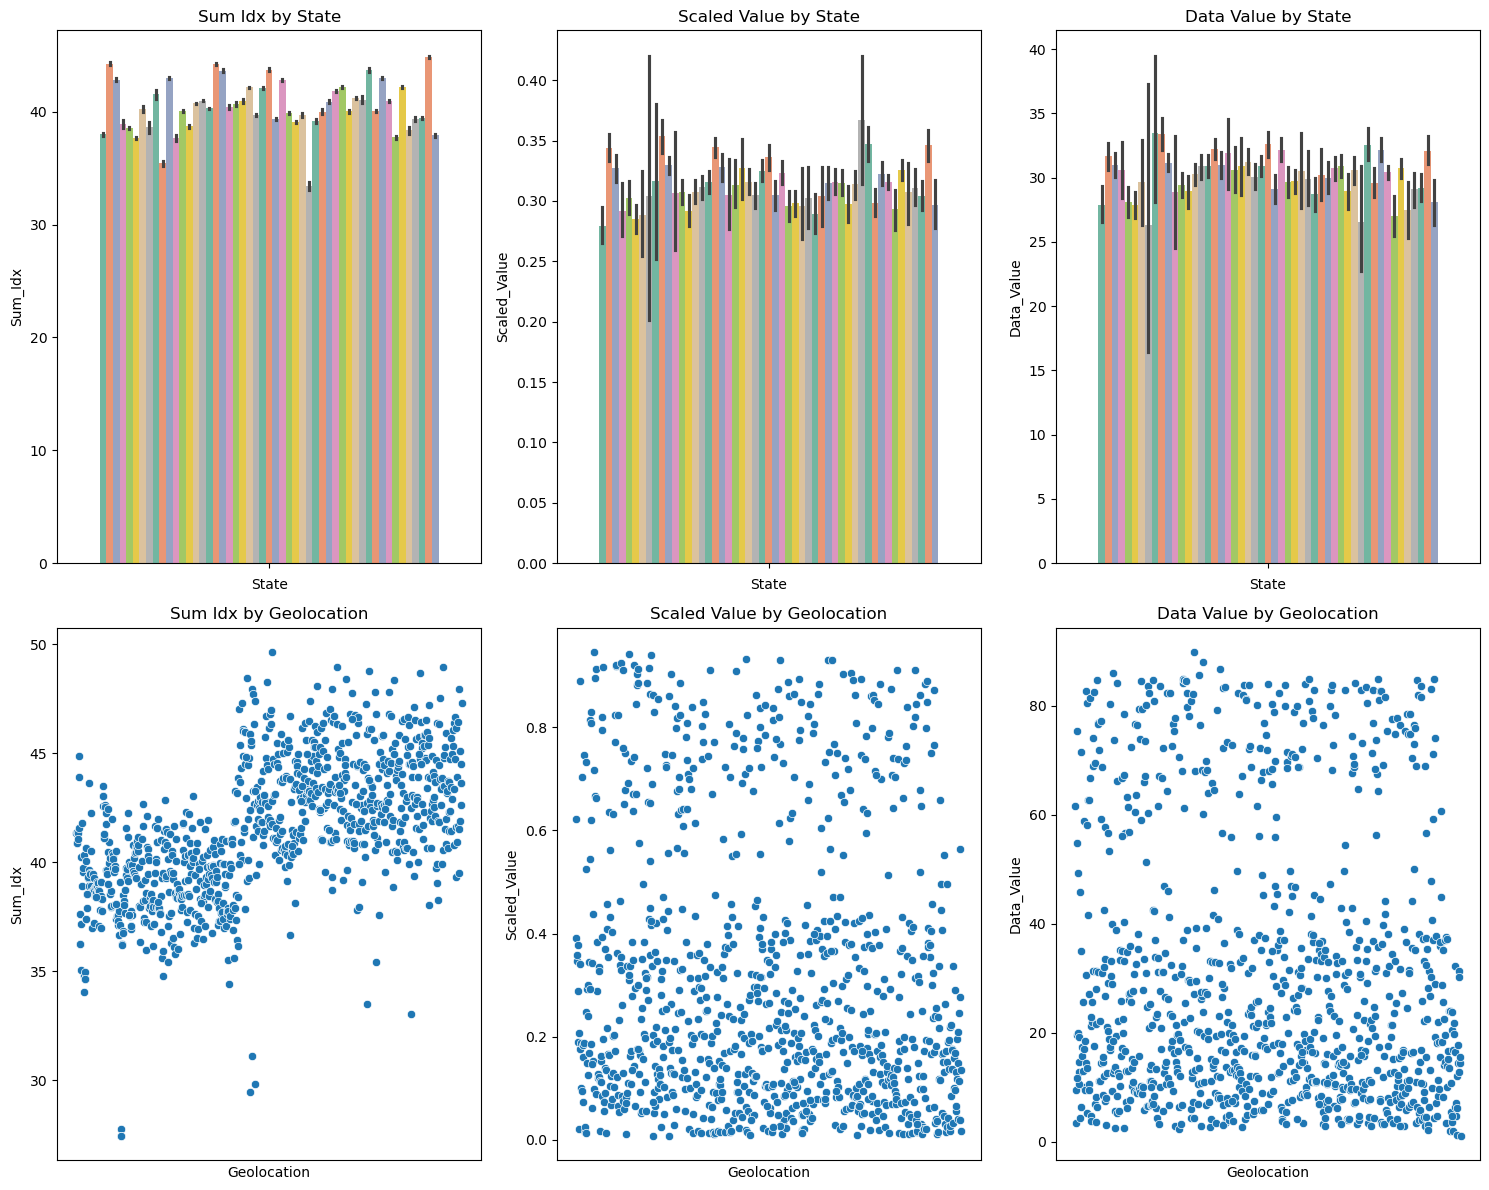

In [56]:
# Helper plotting function

def idx_plot(data,y1,y2,y3,y1_name,y2_name,y3_name):
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))

    # Visualize by State
    # Plot by y1
    sns.barplot(data=data, hue='StateAbbr', y=y1.sample(n=100000), 
                palette='Set2', ax=ax[0,0],legend=False)
    ax[0,0].set_title(f'{y1_name} by State')
    ax[0,0].set_xlabel('State')
    
    # Plot by y2
    sns.barplot(data=data, hue='StateAbbr', y=y2.sample(n=100000), 
                palette='Set2', ax=ax[0,1],legend=False)
    ax[0,1].set_title(f'{y2_name} by State')
    ax[0,1].set_xlabel('State') 

    # Plot by y3
    sns.barplot(data=data, hue='StateAbbr', y=y3.sample(n=100000), 
                palette='Set2', ax=ax[0,2],legend=False)
    ax[0,2].set_title(f'{y3_name} by State')
    ax[0,2].set_xlabel('State') 
    
    # Visualize by Geolocation
    # Plot by y1
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y1, ax=ax[1, 0])
    ax[1, 0].set_title(f'{y1_name} by Geolocation')
    ax[1, 0].set_xlabel('Geolocation')

    ax[1, 0].set_xticks([])
    
    # Plot by y2
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y2, ax=ax[1, 1])
    ax[1, 1].set_title(f'{y2_name} by Geolocation')
    ax[1, 1].set_xlabel('Geolocation')

    ax[1, 1].set_xticks([])

    # Plot by y3
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y3, ax=ax[1, 2])
    ax[1, 2].set_title(f'{y3_name} by Geolocation')
    ax[1, 2].set_xlabel('Geolocation')

    ax[1, 2].set_xticks([])

    plt.tight_layout() 
    plt.show();

idx_plot(df_sum_idx,df_sum_idx['Sum_Idx'],df_sum_idx['Scaled_Value'],df_sum_idx['Data_Value'],'Sum Idx','Scaled Value','Data Value')

Let's see what our distribution looks like with an 'Avg_Idx' vs using raw sum of scaled values. 

In [57]:
# Aggregate Scaled_Value per Geoplocation
avg_idx = df_norm.groupby('Geolocation')['Scaled_Value'].mean().reset_index()
avg_idx.rename({'Scaled_Value': 'Avg_Idx'},axis=1,inplace=True)

# Copy dataframe
df_avg_idx = df_norm.copy()

# Create new column
df_avg_idx = df_avg_idx.merge(avg_idx,on='Geolocation')
df_avg_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798403 entries, 0 to 798402
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            798403 non-null  category
 1   LocationName         798403 non-null  object  
 2   Category             798403 non-null  object  
 3   Data_Value_Type      798403 non-null  object  
 4   Data_Value           798403 non-null  float64 
 5   TotalPopulation      798403 non-null  int64   
 6   Short_Question_Text  798403 non-null  object  
 7   LocationID           798403 non-null  object  
 8   Geolocation          798403 non-null  object  
 9   Scaled_Value         798403 non-null  float64 
 10  Avg_Idx              798403 non-null  float64 
dtypes: category(1), float64(3), int64(1), object(6)
memory usage: 61.7+ MB


When we create an `Avg_Idx` we see still our geolocation distribution but on a different scale and with an inverse relationship. This may mean that certain data types have more weight than others, switching the relationship between the two geographical subsections.

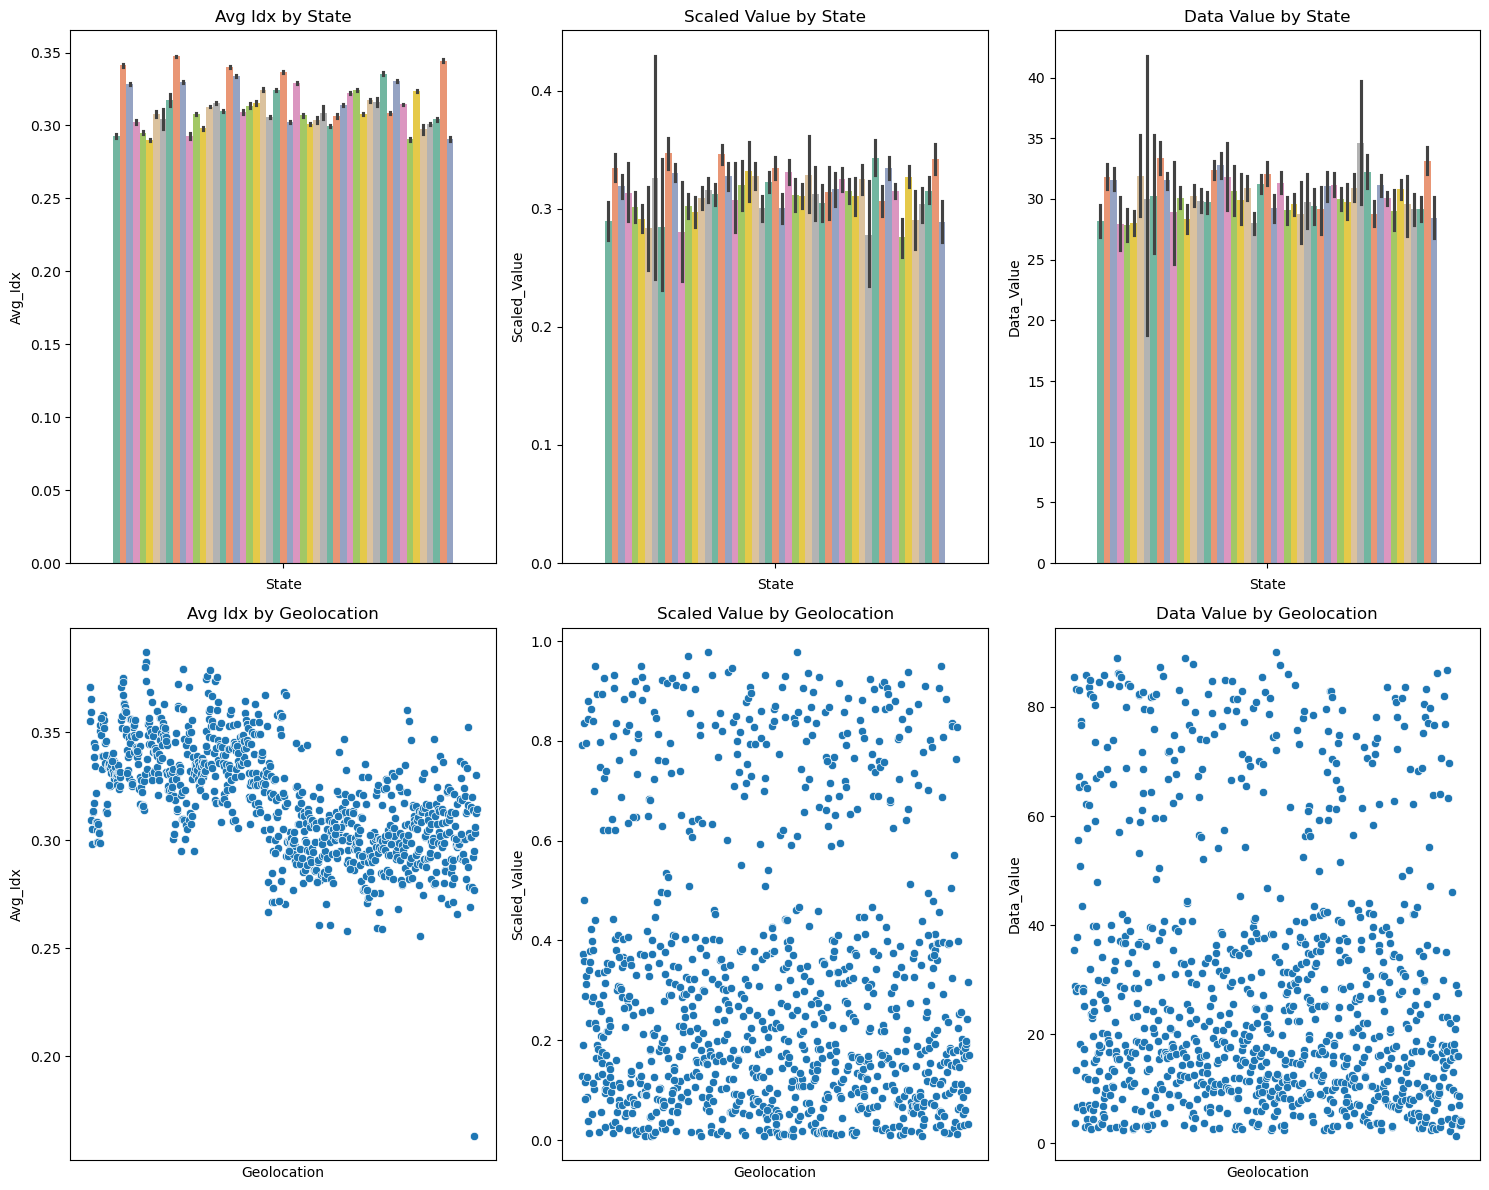

In [58]:
idx_plot(df_avg_idx,df_avg_idx['Avg_Idx'],df_avg_idx['Scaled_Value'],df_avg_idx['Data_Value'],'Avg Idx','Scaled Value','Data Value')

Lastly we will add a population weight to each scaled value, this will adjust our results to consider the density of a region when calculating the HDI.

In [59]:
# Aggregate Scaled_Value per Geoplocation
pw_idx = df_norm.groupby('Geolocation')['TotalPopulation'].sum().reset_index()
pw_idx.rename({'TotalPopulation': 'GeoPop'},axis=1,inplace=True)

# Copy dataframe
df_pw_idx = df_norm.copy()

# Create new column
df_pw_idx = df_pw_idx.merge(pw_idx,on='Geolocation')

# Calculate weights
df_pw_idx['PopWeight'] = df_pw_idx['TotalPopulation']/df_pw_idx['GeoPop']

# Calculate weighted average of health measures
weighted_avg = df_pw_idx.groupby('Geolocation').apply(lambda x: (x['Scaled_Value']*x['PopWeight']).sum()).reset_index(name='Weighted_Idx')

df_pw_idx = df_pw_idx.merge(weighted_avg,on='Geolocation')

df_pw_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798403 entries, 0 to 798402
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            798403 non-null  category
 1   LocationName         798403 non-null  object  
 2   Category             798403 non-null  object  
 3   Data_Value_Type      798403 non-null  object  
 4   Data_Value           798403 non-null  float64 
 5   TotalPopulation      798403 non-null  int64   
 6   Short_Question_Text  798403 non-null  object  
 7   LocationID           798403 non-null  object  
 8   Geolocation          798403 non-null  object  
 9   Scaled_Value         798403 non-null  float64 
 10  GeoPop               798403 non-null  int64   
 11  PopWeight            798403 non-null  float64 
 12  Weighted_Idx         798403 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 73.9+ MB


/var/folders/54/6dlx39k12qb_f13kgx_rz95m0000gn/T/ipykernel_73706/2848633648.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = df_pw_idx.groupby('Geolocation').apply(lambda x: (x['Scaled_Value']*x['PopWeight']).sum()).reset_index(name='Weighted_Idx')


Looks like our weighted average provides more of a spread, and the same relationship as the `Avg_Idx` which means population definitely has an impact on the HDI and geolocation does as well.

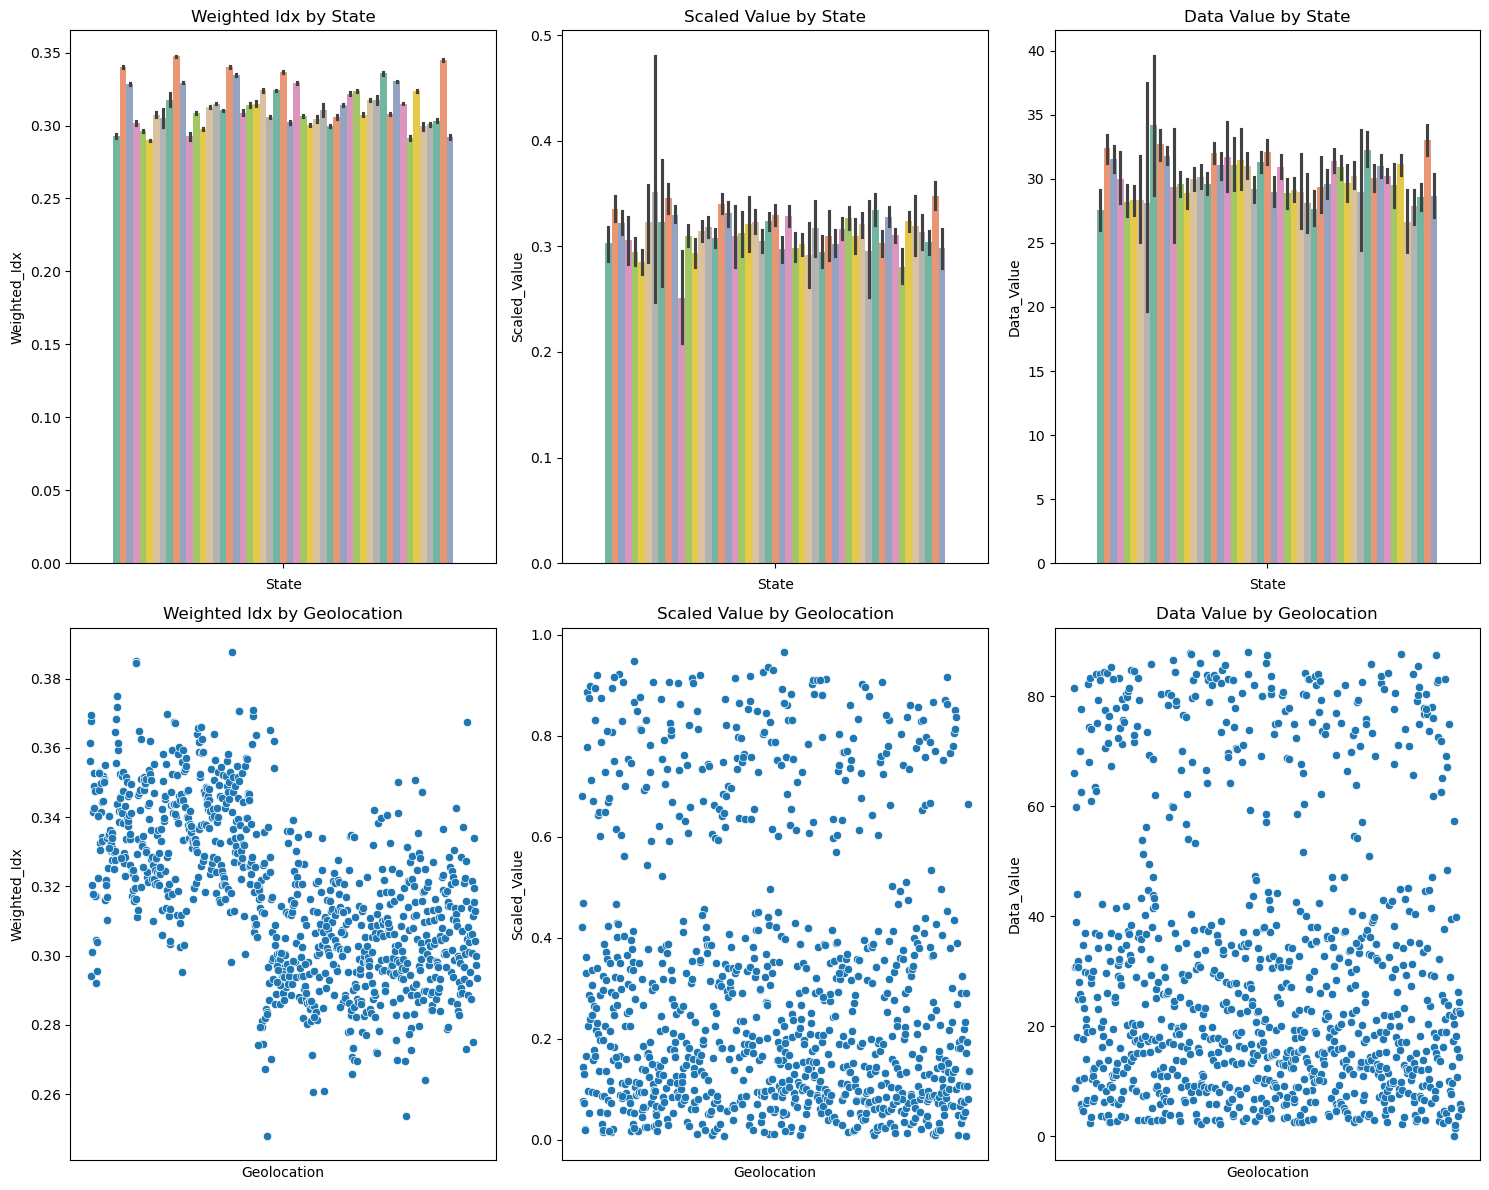

In [60]:
idx_plot(df_pw_idx,df_pw_idx['Weighted_Idx'],df_pw_idx['Scaled_Value'],df_pw_idx['Data_Value'],'Weighted Idx','Scaled Value','Data Value')

### Geolocation to HDI Visualization

Before we finalize our decision to use the population weighted HDI, let's visualize all the index in comparison to population using the `Geolocation`. To do so, we first have to convert the feature to wkt (well-known text) format for use with the geopandas library.

In [69]:
df_pw_idx.loc[:,'Geolocation']= df_pw_idx['Geolocation'].apply(lambda x: x.upper())
df_pw_idx.loc[:,'Geolocation'] = df_pw_idx['Geolocation'].apply(wkt.loads)
df_pw_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798403 entries, 0 to 798402
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            798403 non-null  category
 1   LocationName         798403 non-null  object  
 2   Category             798403 non-null  object  
 3   Data_Value_Type      798403 non-null  object  
 4   Data_Value           798403 non-null  float64 
 5   TotalPopulation      798403 non-null  int64   
 6   Short_Question_Text  798403 non-null  object  
 7   LocationID           798403 non-null  object  
 8   Geolocation          798403 non-null  object  
 9   Scaled_Value         798403 non-null  float64 
 10  GeoPop               798403 non-null  int64   
 11  PopWeight            798403 non-null  float64 
 12  Weighted_Idx         798403 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 73.9+ MB


Now we can create a GeoDataFrame with `Geolocation` as the geometrical feature.

In [70]:
gdf_pw = gpd.GeoDataFrame(df_pw_idx,geometry='Geolocation')

Looking at population and the HDI across all of the geolocations we can see that the higher the population, the lower the HDI. In particular we can see that in part of the west coast, Florida, and part of the east coast demonstrate this inverse relationship.

> This inverse relationship may make sense when you consider factors such as but not limited to; greater access to care, diversity of services, and public health funding in areas with more population density.

This further confirms our decision to use population as a weight for our HDI definition.

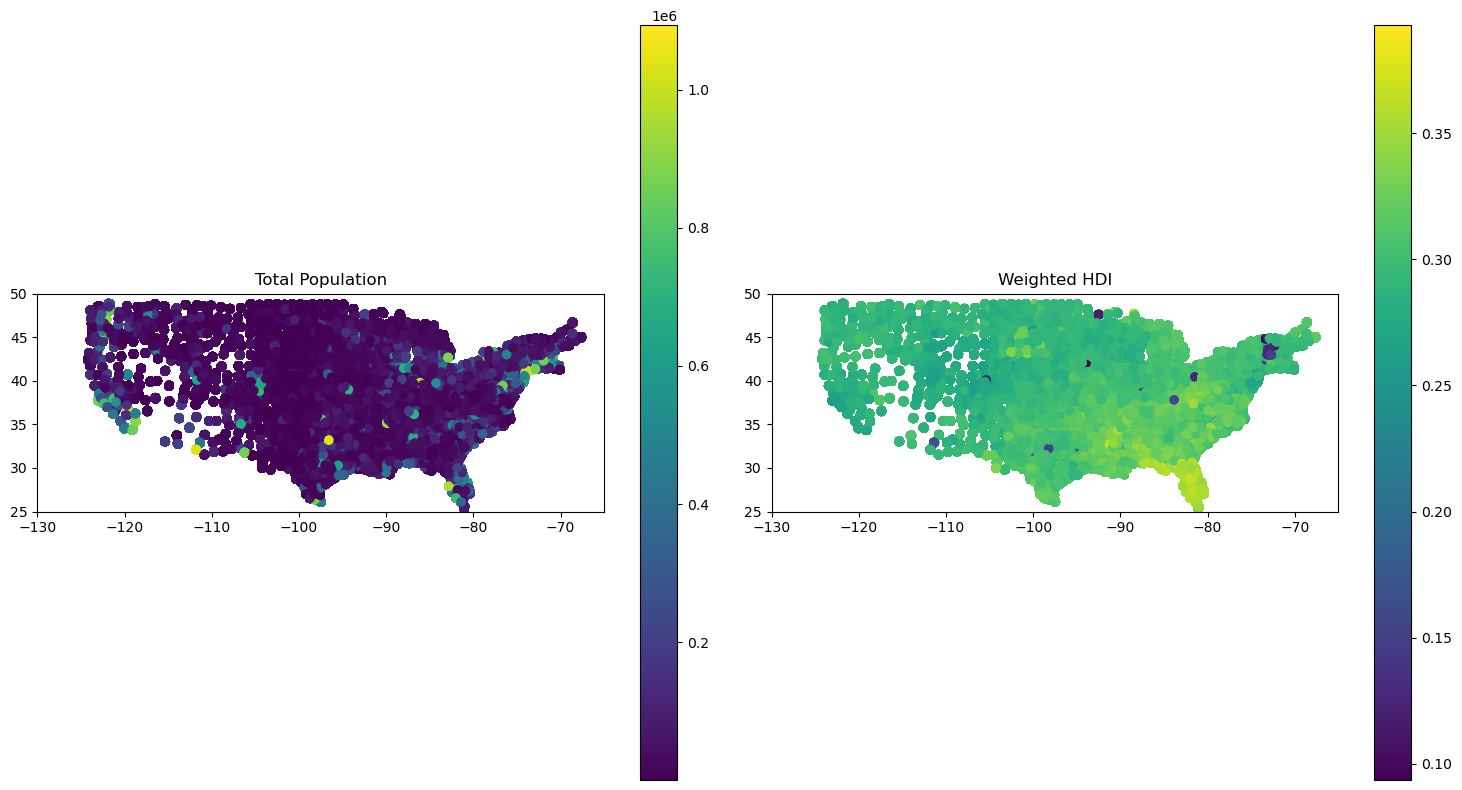

In [71]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

# Plotting 'TotalPopulation'
gdf_pw.plot(column='TotalPopulation', legend=True, ax=ax[0])
ax[0].set_title('Total Population')
ax[0].set_xlim(-130, -65)
ax[0].set_ylim(25, 50)

# Plotting 'Sum_Idx'
gdf_pw.plot(column='Weighted_Idx', legend=True, ax=ax[1])
ax[1].set_title('Weighted HDI')
ax[1].set_xlim(-130, -65)
ax[1].set_ylim(25, 50)

plt.tight_layout();

## 3. Data Preparation

Since our dataset is so large we will train our model on a smaller training set to save computational power and time. We are also going to drop the columns we used to create our `Weighted_Idx`. 

> In future itterations we would want to consider using `Geolocation` to create location features and explore spatial relationships. However, to keep computational cost relatively low, we will note this as a Phase 2 addition.

In [73]:
# Define X, y, and split data

X = df_pw_idx.drop(columns=['Weighted_Idx','GeoPop','PopWeight','Scaled_Value','Geolocation'])
y = df_pw_idx['Weighted_Idx']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

# Initialize StratifiedShuffleSplit
strat_splitter = StratifiedShuffleSplit(n_splits=1,train_size=.09)

# Generate indices for the stratified sample
for train_index, _ in strat_splitter.split(X_train, y_train):
    X_sampled = X.iloc[train_index]
    y_sampled = y.iloc[train_index]
    
# Generate hold-out sets for final model evaluation
# hold_splitter = StratifiedShuffleSplit(n_splits)


X_samp_train, X_samp_test, y_samp_train, y_samp_test = train_test_split(X_sampled,y_sampled)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798403 entries, 0 to 798402
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            798403 non-null  category
 1   LocationName         798403 non-null  object  
 2   Category             798403 non-null  object  
 3   Data_Value_Type      798403 non-null  object  
 4   Data_Value           798403 non-null  float64 
 5   TotalPopulation      798403 non-null  int64   
 6   Short_Question_Text  798403 non-null  object  
 7   LocationID           798403 non-null  object  
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 43.4+ MB


### Base Model and Metrics

In [74]:
# Define num and cat subpipes
subpipe_num = Pipeline(steps=[('ss',StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Initiate ColumnTranformer
CT = ColumnTransformer(transformers=[('subpipe_num',subpipe_num,[4,5]),
                                    ('subpipe_cat',subpipe_cat,[0,1,2,3,6,7])],
                      remainder='passthrough')

# Initial Pipeline
init_pipe = Pipeline(steps=[('ct',CT),
                           ('model',LinearRegression())])

In [75]:
init_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7])])),
                ('model', LinearRegression())])

It looks like our primary RMSE metric is pretty good. R-squared however can stand to improve and we are also seeing some slight overfitting as expected from such a high dimentional feature space.

In [76]:
# Baseline Metrics
print('Train RSME:', root_mean_squared_error(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test RSME:', root_mean_squared_error(y_samp_test,init_pipe.predict(X_samp_test)))
print('Train R-Squared:', r2_score(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test R-Squared:', r2_score(y_samp_test,init_pipe.predict(X_samp_test)))
print('Train MAE:', mean_absolute_error(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test MAE:', mean_absolute_error(y_samp_test,init_pipe.predict(X_samp_test)))

Train RSME: 0.014924008718021279
Test RSME: 0.01610948016506258
Train R-Squared: 0.5785729609107135
Test R-Squared: 0.5066310813757133
Train MAE: 0.013159252526019235
Test MAE: 0.014129799790839937


Even after dropping a significant amount of features, we are left with fairly high dimentionality. This is something we will want to consider as we test and refine our models.

In [45]:
X_train_trans = init_pipe['ct'].transform(X_samp_train)
df_trans = pd.DataFrame(X_train_trans,columns=init_pipe['ct'].get_feature_names_out())
df_trans

,subpipe_num__Data_Value,subpipe_num__TotalPopulation,subpipe_cat__StateAbbr_ak,subpipe_cat__StateAbbr_al,subpipe_cat__StateAbbr_ar,subpipe_cat__StateAbbr_az,subpipe_cat__StateAbbr_ca,subpipe_cat__StateAbbr_co,subpipe_cat__StateAbbr_ct,subpipe_cat__StateAbbr_dc,...,subpipe_cat__LocationID_56027.0,subpipe_cat__LocationID_56029.0,subpipe_cat__LocationID_56031.0,subpipe_cat__LocationID_56033.0,subpipe_cat__LocationID_56035.0,subpipe_cat__LocationID_56037.0,subpipe_cat__LocationID_56039.0,subpipe_cat__LocationID_56041.0,subpipe_cat__LocationID_56043.0,subpipe_cat__LocationID_56045.0
0,-0.939301,-0.482894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.084320,-0.471940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.973229,-0.474906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.096305,-0.410520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.655639,-0.368883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40414,2.097081,-0.435181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40415,1.865357,-0.510980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40416,2.021172,4.968629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40417,0.119438,-0.496273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Linear Regression Model

Let's see if we can address the overfitting we are seeing in our baseline metrics.

### Lasso

In [78]:
# Replace in pipeline

lasso_pipe = init_pipe.set_params(model=Lasso(max_iter=1000))
lasso_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7])])),
                ('model', Lasso())])

In [82]:
mcv_lasso = MetricsCV(lasso_pipe,'Lasso',X_samp_train,y_samp_train)

space_lasso = [Real(10**-4,10**3,'log-uniform',name='alpha'),
              Categorical(['cyclic','random'],name='selection')]



val_scores, lasso_best = mcv_lasso.objective(space=space_lasso,scoring='neg_root_mean_squared_error',
                                           verbose=3, n_calls=30, n_initial_points=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 27.2508
Function value obtained: 0.0230
Current minimum: 0.0230
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.7266
Function value obtained: 0.0229
Current minimum: 0.0229
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 39.0492
Function value obtained: 0.0230
Current minimum: 0.0229
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.9955
Function value obtained: 0.0229
Current minimum: 0.0229
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 46.6698
Function value obtained: 0.0186
Current minimum: 0.0186
Iteration No: 6 started. Evalu

<bound method Pipeline.get_params of Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7])])),
                ('model', Lasso(alpha=0.0001, selection='random'))])>

In [ ]:
# View best params
lasso_best['model'].get_params

In [84]:
test_scores = mcv_lasso.test_metrics(X_samp_test,y_samp_test)
display(val_scores)
test_scores

/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model Name,Val Train Score,Val Test Score
0,Lasso,0.018069,0.018069


,Model Name,Train Score,Test Score,Train R2,Test R2,Train MAE,Test MAE
0,Lasso,0.018048,0.017998,0.383659,0.384179,0.015423,0.015339


### Ridge

Now we can assess the Ridge model in comparison to Lasso to see which type of regularization is best for our problem.

In [85]:
# Replace in pipeline

ridge_pipe = init_pipe.set_params(model=Ridge())
ridge_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7])])),
                ('model', Ridge())])

In [ ]:
mcv_ridge = MetricsCV(ridge_pipe,'Ridge',X_samp_train,y_samp_train)

space_ridge = [Real(10**-4,10**3,'log-uniform',name='alpha'),
              Categorical(['auto','cholesky','lsqr','sag'],name='solver'),
              Real(10**-3,10**-1,'log-uniform',name='tol')]



val_scores, ridge_best = mcv_ridge.objective(space=space_ridge,scoring='neg_root_mean_squared_error',
                                           verbose=3, n_calls=20, n_initial_points=10,val_df=val_scores)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 30.8556
Function value obtained: 0.0166
Current minimum: 0.0166
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 32.8019
Function value obtained: 0.0163
Current minimum: 0.0163
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 34.0976
Function value obtained: 0.0165
Current minimum: 0.0163
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 34.6320
Function value obtained: 0.0163
Current minimum: 0.0163
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 34.7285
Function value obtained: 0.0180
Current minimum: 0.0163
Iteration No: 6 started. Evalu

In [ ]:
# View best params
ridge_best['model'].get_params

In [ ]:
test_scores = mcv_ridge.test_metrics(X_samp_test,y_samp_test,test_df=test_scores)
display(val_scores)
test_scores

## Gradient Boosting

To address the low $R^2$ we see in our linear model, we will try some gradient boosting algorithms to see if we can increase the complexity and explain more of the data through our model. 

In [ ]:
# Replace in pipeline

ada_pipe = init_pipe.set_params(model=AdaBoostRegressor())
ada_pipe.fit(X_samp_train,y_samp_train)

In [ ]:
mcv_ada = MetricsCV(ada_pipe,'AdaBoost',X_samp_train,y_samp_train)

space_ada = [Real([0.05, 0.1, 0.2, 0.3, 0.4],name='learning_rate'),
              Categorical([200, 500, 1000],name='n_estimators')]



val_scores, ada_best = mcv_ada.objective(space=space_ada,scoring='neg_root_mean_squared_error',
                                           verbose=3, n_calls=20, n_initial_points=10,val_df=val_scores)

In [ ]:
# View best params
ada_best['model'].get_params

It looks like this improved our $R^2$ significantly! However, our error metrics suffered a little bit.

In [ ]:
test_scores = mcv_ada.test_metrics(X_samp_test,y_samp_test,test_df=test_scores)
display(val_scores)
test_scores

## DecisionTree

In [ ]:
# Replace in pipeline

dec_pipe = ada_pipe.set_params(model=DecisionTreeRegressor())
dec_pipe.fit(X_samp_train,y_samp_train)

In [ ]:
mcv_dec = MetricsCV(dec_pipe,'AdaBoost',X_samp_train,y_samp_train)

space_dec = [Real([None, 10, 20, 30, 40],name='max_depth'),
             Categorical(['squared_error', 'absolute_error'], name='criterion'), 
             Real([5, 10, 20, 50],name='min_samples_split'),
             Real([None,10,30,40],name='max_leaf_nodes'), 
             Real([3, 5, 7, 10], name='min_samples_leaf'), 
             Categorical(['auto','sqrt','log2'],name='max_features')]



val_scores, dec_best = mcv_dec.objective(space=space_dec,scoring='neg_root_mean_squared_error',
                                           verbose=3, n_calls=20, n_initial_points=10,val_df=val_scores)

In [ ]:
# View best params
dec_best['model'].get_params

In [ ]:
test_scores = mcv_dec.test_metrics(X_samp_test,y_samp_test,test_df=test_scores)
display(val_scores)
test_scores